# Проект по стартапу, который продает продукты питания

Цель проекта - разобраться, как ведут себя пользователи вашего мобильного приложения. Необходимо изучить воронку продаж и исследовать результаты A/A/B-эксперимента. Дизайнеры приложения приняли решение поменять шрифты во всём приложении, поэтому нам нужно проанализировать результаты теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним, какой же шрифт лучше.

## План:
**[1. Изучение файла](#the_destination)**

**[2. Предобработка](#the_destination1)**
- замена названий столбцов
- проверка пропусков, дубликатов
- корректировка типов данных
- добавление столбца даты

**[3. Изучение данных и ответы на вопросы:](#the_destination2)**
- Сколько всего событий в логе?
- Сколько всего пользователей в логе?
- Сколько в среднем событий приходится на пользователя?
- Данными за какой период располагаем? А на самом деле?
- Много ли событий и пользователей мы потеряли, отбросив старые данные?
- Есть ли у нас пользователи из всех трёх экспериментальных групп?

**[4. Изучение воронки событий](#the_destination3)**
- Какие события есть в логах, как часто они встречаются?
- Сколько пользователей совершали каждое из этих событий?
- В каком порядке происходят события? Все ли они выстраиваются в последовательную цепочку?
- Какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем)?
- На каком шаге теряем больше всего пользователей?
- Какая доля пользователей доходит от первого события до оплаты?

**[5. Изучим результаты эксперимента](#the_destination4)**
- Сколько пользователей в каждой экспериментальной группе?
- Находят ли статистические критерии разницу между выборками 246 и 247?
- Можно ли сказать, что разбиение на группы работает корректно?
- Аналогично поступим с группой с изменённым шрифтом. Какие выводы из эксперимента можно сделать?
- Какой уровень значимости был выбран при проверке статистических гипотез? Какой уровень значимости стоит применить?

**[Общий вывод](#the_destination5)**

На основе этого плана можно приступить к изучению воронки и А/В тестов.

## Посмотрим наш датасет
<a id='the_destination'></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import numpy as np
import math

In [ ]:
data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [ ]:
data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


В нашем датасете 244 126 строк, 4 столбца:

`EventName` — название события;

`DeviceIDHash` — уникальный идентификатор пользователя;

`EventTimestamp` — время события;

`ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Предобработка
<a id='the_destination1'></a>

In [ ]:
# изменим названия столбцов
data = data.rename(columns={'EventName': 'event_name',
                            'DeviceIDHash': 'user_id',
                            'EventTimestamp': 'event_time',
                            'ExpId': 'exp_id'})

In [ ]:
# проверим пропуски
data.isna().sum()

event_name    0
user_id       0
event_time    0
exp_id        0
dtype: int64

In [ ]:
# проверим дубликаты
data.duplicated().sum()

413

In [ ]:
# удалим дубликаты
data = data.drop_duplicates().reset_index(drop=True)

In [ ]:
# изменим тип данных
data['event_time'] = pd.to_datetime(data['event_time'], unit='s')
data.head()

,event_name,user_id,event_time,exp_id
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


In [ ]:
# добавим отдельный столбец по дате
data['event_date'] = data['event_time'].astype('datetime64[D]')
data['event_date'] = data['event_date'].dt.strftime('%Y-%m-%d')
data.head()

,event_name,user_id,event_time,exp_id,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


В процессе предобработки лог-файла:
- не были обнаружены пропуски
- были найдены и удалены 413 дубликатов, которые вероятно появились в связи с технической ошибкой
- были изменены названия столбцов (по "змеиному" регистру) в более оптимальный вид
- формат даты и времени в столбце `event_time` был приведен к правильному варианту
- был добавлен новый столбец `event_date` с информацией о дате события

## Изучим и проверим данные
<a id='the_destination2'></a>

### Сколько всего событий в логе?

In [ ]:
# количество событий
data['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [ ]:
len(data)

243713

Всего в логе 5 видов событий (всего событий 243713):
- MainScreenAppear,
- PaymentScreenSuccessful,
- CartScreenAppear,
- OffersScreenAppear,
- Tutorial.

### Сколько всего пользователей в логе?

In [ ]:
# количество пользователей
data['user_id'].value_counts().count()

7551

В логе 7551 пользователь.

### Сколько в среднем событий приходится на пользователя?

In [ ]:
# среднее количество событий на 1 пользователя
data.shape[0] / data['user_id'].nunique()

32.27559263673685

На 1 пользователя в среднем приходится 32 события.

### За какой период у нас данные? Как меняется количество данных? Данными за какой период мы располагаем на самом деле?

In [ ]:
data['event_date'].min()

'2019-07-25'

In [ ]:
data['event_date'].max()

'2019-08-07'

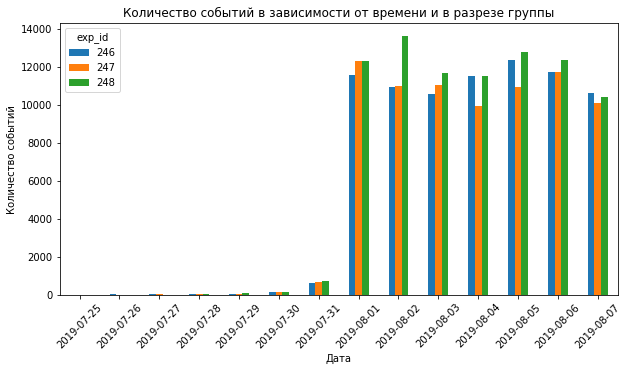

In [ ]:
# сгруппируем данные по дате и группе, посчитаем количество событий в каждой группе и построим диаграмму
grouped_data = data.groupby(['event_date', 'exp_id']).size().unstack(fill_value=0)
grouped_data.plot(kind='bar', figsize=(10, 5))

plt.title('Количество событий в зависимости от времени и в разрезе группы')
plt.ylabel('Количество событий')
plt.xlabel('Дата')
plt.xticks(rotation=45)

plt.show()

Полными являются данные только за период от 1 до 7 августа 2019 года. Данные до 1 августа придется отбросить.

In [ ]:
# выберем нужный период
good_data = data.query('event_date >= "2019-08-01"')

### Много ли событий и пользователей было потеряно при отбросе старых данных?

In [ ]:
user_lost = data['user_id'].nunique() - good_data['user_id'].nunique()
user_lost

17

In [ ]:
# посчитаем также долю удаленных пользователей
user_lost / data['user_id'].nunique() * 100

0.22513574361011784

Было потеряно 17 пользователей (= 0.22% от количества пользователей из первичного датасета).

In [ ]:
event_lost = len(data) - len(good_data)
event_lost

2826

In [ ]:
event_lost / len(data) * 100

1.159560630741897

Было потеряно 2826 событий, что является 1.15% от изначального датасета.

In [ ]:
# среднее количество событий на 1 пользователя
good_data.shape[0] / good_data['user_id'].nunique()

31.97332094504911

### Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.

In [ ]:
good_data.groupby(by=['exp_id'])['user_id'].nunique()

exp_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

Во всех группах есть приблизительно одинаковое количество пользователей.

**Промежуточный вывод:**

В логе 243 713 событий 5 видов, 7551 пользователь, на 1 пользователя в среднем приходится 32 события. Однако датасет пришлось урезать, так как до 1 августа 2019 года данные собирались не полные.

В обновленном датасете 240 887 событий, 7534 пользователей, то есть на 1 пользователя в среднем приходится 31.9 события.

## Изучим воронку событий
<a id='the_destination3'></a>

### Какие события есть в логах, как часто они встречаются? Отсортируем события по частоте.

In [ ]:
good_data.groupby(by='event_name')['event_name'].count().sort_values(ascending=False)

event_name
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Есть 5 видов событий: MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful, Tutorial.

Чаще всего встречается событие "MainScreenAppear" (117 328) - появление главного экрана (или домашней страницы). Реже всего "Tutorial" (1005).

### Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.

In [ ]:
# создаздим таблицу по событиям и количеству пользователей
user_events = good_data.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).to_frame()
user_events = user_events.rename(columns={'user_id':'user_count'})
user_events.reset_index(inplace=True)

user_events

,event_name,user_count
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


In [ ]:
good_data['user_id'].nunique()

7534

In [ ]:
user_events['percent'] = (user_events['user_count'] / good_data['user_id'].nunique()).round(3) * 100
user_events

,event_name,user_count,percent
0,MainScreenAppear,7419,98.5
1,OffersScreenAppear,4593,61.0
2,CartScreenAppear,3734,49.6
3,PaymentScreenSuccessful,3539,47.0
4,Tutorial,840,11.1


Наибольшее количество пользователей проходит через основной экран (7419, 98.5%), затем идет OffersScreenAppear (4593), CartScreenAppear	(3734), PaymentScreenSuccessful	(3539), и наименьшее через Tutorial	(840, 11.1%).

### Предположим, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.

Исходя из данных прошлого задания, можно предположить, что события происходят в следующем порядке:
1. MainScreenAppear - главный экран,
2. OffersScreenAppear - экран с предложением товаров/услуг/продуктов,
3. CartScreenAppear - корзина с понравившимися товарами,
4. PaymentScreenSuccessful - экран совершившейся оплаты покупки.

Событие Tutorial не встраивается в эту цепочку, вероятно потому что интерфейс приложения достаточно понятен, чтобы только малому количеству пользователей потребовалось пройти курс обучения перед тем, как совершать покупки. Далее не будем учитывать это событие.

In [ ]:
good_data = good_data.query('event_name != "Tutorial"')

### По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).
То есть для последовательности событий A → B → C посчитаем отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

In [ ]:
user_events.drop(user_events.tail(1).index, inplace=True)

In [ ]:
user_events['conversion'] = 1
for i in range(1, 4):
    user_events.iloc[i, user_events.columns.get_loc('conversion')] = user_events.iloc[i, user_events.columns.get_loc('user_count')] / user_events.iloc[i-1, user_events.columns.get_loc('user_count')]

user_events

,event_name,user_count,percent,conversion
0,MainScreenAppear,7419,98.5,1.000000
1,OffersScreenAppear,4593,61.0,0.619086
2,CartScreenAppear,3734,49.6,0.812976
3,PaymentScreenSuccessful,3539,47.0,0.947777


После главного экрана на экран предложений попадает ~62% пользователей. Откуда в корзину переходит 81%, а после нее оплачивают покупку уже ~95% пользователей.

### На каком шаге теряем больше всего пользователей?

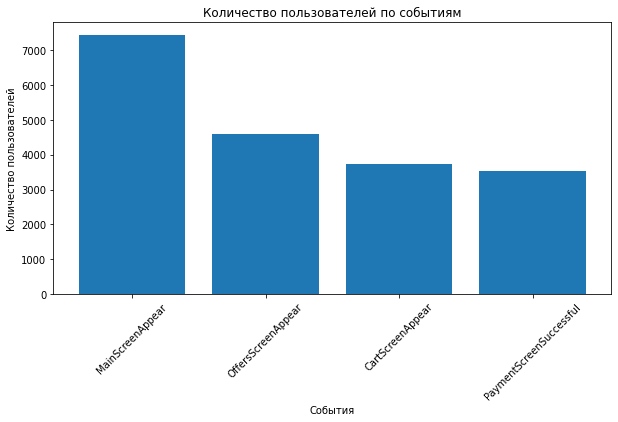

In [ ]:
plt.figure(figsize=(10, 5))
plt.bar(user_events['event_name'], user_events['user_count'])
plt.title('Количество пользователей по событиям')
plt.xlabel('События')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=45)
plt.show()

Наибольшее количество пользователей теряется на переходе с главного экрана на экран предложений.

### Какая доля пользователей доходит от первого события до оплаты?

In [ ]:
# посчитаем долю пользователей
user_events.loc[3, 'user_count'] / user_events.loc[0, 'user_count'] * 100

47.70184661005526

От первого события (главный экран) до последнего события (оплата покупки) доходит 47.7% пользователей.

**Промежуточный вывод:**

Наибольшее количество пользователей проходит через основной экран (7419, 98.5%), затем идет OffersScreenAppear (4593), CartScreenAppear (3734), PaymentScreenSuccessful (3539), и наименьшее через Tutorial (840, 11.1%). Из цепочки уберем событие Tutorial, потому что оно не встраивается в эту цепочку.

После главного экрана на экран предложений попадает ~62% пользователей. Откуда в корзину переходит 81%, а после нее оплачивают покупку уже ~95% пользователей. Наибольшее количество пользователей теряется на переходе с главного экрана на экран предложений. От первого события (главный экран) до последнего события (оплата покупки) доходит 47.7% пользователей.

##  Изучим результаты эксперимента
<a id='the_destination4'></a>

### Сколько пользователей в каждой экспериментальной группе?

In [ ]:
good_data.groupby('exp_id')['user_id'].nunique()

exp_id
246    2483
247    2512
248    2535
Name: user_id, dtype: int64

В каждой экспериментальной группе около 2500 пользователей.

### Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.

In [ ]:
group_246 = good_data[good_data['exp_id'] == 246].groupby('exp_id')['user_id'].nunique().reset_index()
group_247 = good_data[good_data['exp_id'] == 247].groupby('exp_id')['user_id'].nunique().reset_index()

ratio = 1 - group_246.iloc[0]['user_id'] / group_247.iloc[0]['user_id']
print('Разница между выборками = {:.2%}'.format(ratio))

Разница между выборками = 1.15%


Разница между группами незначительная.

### Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп, и долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным.

Повторим то же самое для всех других событий. Можно ли сказать, что разбиение на группы работает корректно?

Самым популярным событием является посещение главной страницы.

In [ ]:
main_screen = good_data[good_data['event_name'] == "MainScreenAppear"].groupby('exp_id')['user_id'].nunique().to_frame().reset_index()
main_screen['percent'] = (main_screen['user_id'] / good_data['user_id'].nunique()).round(3) * 100
main_screen

,exp_id,user_id,percent
0,246,2450,32.5
1,247,2476,32.9
2,248,2493,33.1


Цифровые значения показывают нам, что в каждой группе около 2450-2500 (32-33%) пользователей совершили самое популярное событие, проверим, будет ли отличие между группами статистически достоверным. Попробуем сделать сразу с проверкой других событий.

Сформулируем гипотезы

Н0: Различий между долями пользователей разных групп при совершении события нет.

Н1: Различия между долями пользователей разных групп при совершении события есть.

alpha возьмем 0.05.

In [ ]:
#напишем функцию для статистической значимости

def z_test(dataframe, exp_group, alpha):
    #пользователи в каждой группе
    users = [dataframe.query('exp_id == @group')['user_id'].nunique() for group in exp_group]
    #перебор экспериментальных групп по событиям и количество пользователей
    for event in dataframe.event_name.unique():
        events = [dataframe.query('exp_id == %d and event_name == "%s"' % (group, event))['user_id'].nunique() for group in exp_group]

        p1 = events[0] / users[0]
        p2 = events[1] / users[1]

        p_combined = sum(events) / sum(users)

        difference = p1 - p2

        z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1 / users[0] + 1 / users[1]))

        distr = st.norm(0, 1)
        p_value = (1 - distr.cdf(abs(z_value))) * 2

        print('Проверка групп:', exp_group)
        print('Название события:', event)
        print('p-value: {p_value:}'.format(p_value=p_value))

        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: Различия между долями есть')
        else:
            print('Не получилось отвергнуть нулевую гипотезу: Различий между долями нет')
        print(' ')

Проверим гипотезы по равенству долей 246 и 247 групп, как равенству двух средних друг другу.

In [ ]:
z_test(good_data, [246, 247], .05)

Проверка групп: [246, 247]
Название события: MainScreenAppear
p-value: 0.7526703436483038
Не получилось отвергнуть нулевую гипотезу: Различий между долями нет
 
Проверка групп: [246, 247]
Название события: OffersScreenAppear
p-value: 0.24786096925282264
Не получилось отвергнуть нулевую гипотезу: Различий между долями нет
 
Проверка групп: [246, 247]
Название события: CartScreenAppear
p-value: 0.22867643757335676
Не получилось отвергнуть нулевую гипотезу: Различий между долями нет
 
Проверка групп: [246, 247]
Название события: PaymentScreenSuccessful
p-value: 0.11446627829276612
Не получилось отвергнуть нулевую гипотезу: Различий между долями нет
 


Разбиение на группы работает корректно, тест показал, что статистически значимых различий между группами нет.

### Аналогично поступим с группой с изменённым шрифтом.

Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?

In [ ]:
# проверим равенство долей 246 и 248
z_test(good_data, [246, 248], .05)

Проверка групп: [246, 248]
Название события: MainScreenAppear
p-value: 0.3387114076159288
Не получилось отвергнуть нулевую гипотезу: Различий между долями нет
 
Проверка групп: [246, 248]
Название события: OffersScreenAppear
p-value: 0.21442476639710506
Не получилось отвергнуть нулевую гипотезу: Различий между долями нет
 
Проверка групп: [246, 248]
Название события: CartScreenAppear
p-value: 0.08067367598823139
Не получилось отвергнуть нулевую гипотезу: Различий между долями нет
 
Проверка групп: [246, 248]
Название события: PaymentScreenSuccessful
p-value: 0.21693033984516674
Не получилось отвергнуть нулевую гипотезу: Различий между долями нет
 


Статистически значимых различий между группами (**первая** контрольная группа и группа с измененным шрифтом) нет.

In [ ]:
# проверим равенство долей 247 и 248
z_test(good_data, [247, 248], .05)

Проверка групп: [247, 248]
Название события: MainScreenAppear
p-value: 0.5194964354051703
Не получилось отвергнуть нулевую гипотезу: Различий между долями нет
 
Проверка групп: [247, 248]
Название события: OffersScreenAppear
p-value: 0.9333751305879443
Не получилось отвергнуть нулевую гипотезу: Различий между долями нет
 
Проверка групп: [247, 248]
Название события: CartScreenAppear
p-value: 0.5878284605111943
Не получилось отвергнуть нулевую гипотезу: Различий между долями нет
 
Проверка групп: [247, 248]
Название события: PaymentScreenSuccessful
p-value: 0.7275718682261119
Не получилось отвергнуть нулевую гипотезу: Различий между долями нет
 


Статистически значимых различий между группами (**вторая** контрольная группа и группа с измененным шрифтом) нет.

In [ ]:
# проверим равенство долей объединенных 246+247 и 248

exp_groups_together = good_data.copy()
exp_groups_together['exp_id'].replace({247: 246}, inplace=True)

z_test(exp_groups_together, [246, 248], .05)

Проверка групп: [246, 248]
Название события: MainScreenAppear
p-value: 0.3486684291093256
Не получилось отвергнуть нулевую гипотезу: Различий между долями нет
 
Проверка групп: [246, 248]
Название события: OffersScreenAppear
p-value: 0.44582745409482394
Не получилось отвергнуть нулевую гипотезу: Различий между долями нет
 
Проверка групп: [246, 248]
Название события: CartScreenAppear
p-value: 0.18683558686831558
Не получилось отвергнуть нулевую гипотезу: Различий между долями нет
 
Проверка групп: [246, 248]
Название события: PaymentScreenSuccessful
p-value: 0.6107918742187335
Не получилось отвергнуть нулевую гипотезу: Различий между долями нет
 


Статистически значимых различий между группами (**объединенные** контрольные группы и группа с измененным шрифтом) нет.

### Какой уровень значимости был выбран при проверке статистических гипотез выше?
Посчитаем, сколько проверок статистических гипотез было сделано. При уровне значимости 0.1 в 10% случаев можно ошибочно отклонить нулевую гипотезу при условии, что она верна. Какой уровень значимости стоит применить? Можно изменить его, проделать предыдущие пункты и проверить выводы.

**Был выбран уровень значимости 0.05. Всего было проведено 16 проверок статистических гипотез.**

Применим метод Бонферрони. Необходимо поделить уровень значимости ɑ на число гипотез.
В нашем случае это:

In [ ]:
0.05 / 16

0.003125

Поэтому уровень значимости, который следует применить, равен 0.003125. Однако во всех проверках за исключением одной (проверка групп 246 и 248 по событию "CartScreenAppear", в котором p-value = 0.08) p-value значительно выше изначального уровня значомсти в 0.05.

**Промежуточный вывод:**

В каждой экспериментальной группе около 2500 пользователей. Между долями всех трех групп по событиям различий нет, изменение шрифта никак не повлияло на пользователей.

## Вывод
<a id='the_destination5'></a>

В рамках данного проекта перед намстояла задача изучения поведения пользователей приложения, а именно групп A/A/B после внедрения измененного шрифта. Изначальный датасет состоял из 244 126 строк, 4 столбцов:

- `EventName` — название события;
- `DeviceIDHash` — уникальный идентификатор пользователя;
- `EventTimestamp` — время события;
- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

Была проведена предобработка, в ходе которой не были обнаружены пропуски, но были найдены и удалены 413 дубликатов, которые вероятно появились в связи с технической ошибкой. Для дальнейшей работы также были изменены названия столбцов, формат даты.

**Промежуточные выводы**

Информация о логе:
1. В логе 243 713 событий 5 видов, 7551 пользователь, на 1 пользователя в среднем приходится 32 события. Однако датасет пришлось урезать, так как до 1 августа 2019 года данные собирались не полные.
2. В обновленном датасете 240 887 событий, 7534 пользователей, то есть на 1 пользователя в среднем приходится 31.9 события.

Воронка событий:
1. Наибольшее количество пользователей проходит через основной экран (7419, 98.5%), затем идет OffersScreenAppear (4593), CartScreenAppear (3734), PaymentScreenSuccessful (3539), и наименьшее через Tutorial (840, 11.1%). Из цепочки уберем событие Tutorial, потому что оно не встраивается в эту цепочку.
2. После главного экрана на экран предложений попадает ~62% пользователей. Откуда в корзину переходит 81%, а после нее оплачивают покупку уже ~95% пользователей. Наибольшее количество пользователей теряется на переходе с главного экрана на экран предложений. От первого события (главный экран) до последнего события (оплата покупки) доходит 47.7% пользователей.

Результаты A/A/B-теста:
- В каждой экспериментальной группе около 2500 пользователей. Между долями всех трех групп по разным события различий нет, изменение шрифта никак не повлияло на поведение пользователей.

На основании анализа рекомендуется остановить тест и зафиксировать отсутствие различий между группами.